In [ ]:
!nvidia-smi

Mon Mar 11 05:22:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Getting data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 18.97 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# Check what files are in PubMed 20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [ ]:
# Starting experiment using 20k dataset with @ sign
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all filenames in the target directory
import os
filenames=[data_dir+ filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

In [ ]:
# create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
  filename: String containing the target filepath.

  Returns:
  list of strings with one string per line from target filename.
  """
  with open(filename,'r') as f:
    return f.readlines()

In [ ]:
# Readin train lines
train_lines=get_lines(data_dir+"train.txt") # Read lines with training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

## Data should look like this
List of dictonaries
```
[
    {
        'line_number':0,
        'target':'BACKGROUND',
         
         'text':"Emotional eating.........
        
         'total_lines':11
    }

]
```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictonaries of abstract line data.

  Takes in filename,reads it contentand sort through each line,

  extracting things like target label,the text of the sentences,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines=get_lines(filename) # Get all lines from filename
  abstract_lines=""#create empty abbstract
  abstract_samples=[] # Create empty list of abstract

  #loop through each line in target file
  for line in input_lines:
    if line.startswith("###"):#Check to see if line is id line
      abstract_id=line
      abstract_lines=""#reset the abstract string if the line is an ID line
    elif line.isspace():#Check to see if line is a new line
      abstract_line_split=abstract_lines.splitlines()# split abstract into seperate lines

      #Iterate through each line in a single abstract and count them at the same time

      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
        line_data={} #Create an empty dictionary for each line
        target_text_split=abstract_line.split("\t")# split target label from text
        line_data["target"]=target_text_split[0]#get target label
        line_data["text"]=target_text_split[1].lower()#Get target text
        line_data["line_number"]=abstract_line_number#what number does the line appear in abstract
        line_data["total_lines"]=len(abstract_line_split)-1 #How many lines are there in target abstract?
        abstract_samples.append(line_data)
    else: #If above conditions are'nt fulfilled , the line containes a labelled sentence
      abstract_lines+=line

  return abstract_samples





In [ ]:
#Get data from file and preprocess it
%%time
train_samples=preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples=preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples=preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135
CPU times: user 733 ms, sys: 122 ms, total: 855 ms
Wall time: 1.12 s


In [ ]:
# Checking first abstract of training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

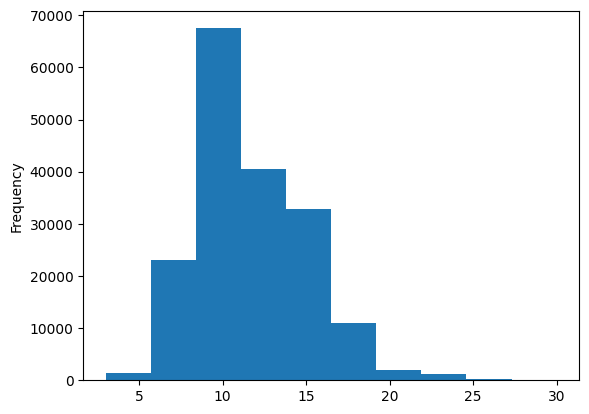

In [ ]:
# Let's check length of different lines
train_df["total_lines"].plot.hist()

### Get list of sentences

In [ ]:
#Convert abstract text lines into lists
train_sentences=train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()

In [ ]:
#View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Make numeric labels

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot=one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_onne_hot=one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [ ]:
# Extract labels (target) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded=label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded=label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEnoder instance
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Series of Modelling experoments

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0=Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

#Fit pipeline
model_0.fit(X=train_sentences,
            y=train_labels_encoded
            )

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded
                 )

0.7218323844829869

In [ ]:
#Make predictions using baseline model
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
!wget https://raw.githubusercontent.com/Muditkumar123/Deep_learning_Projects-/main/helper_functions.py

--2024-03-11 05:22:37--  https://raw.githubusercontent.com/Muditkumar123/Deep_learning_Projects-/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-11 05:22:37 (66.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
#Calculate baseline results
baseline_results=calculate_results(y_true=val_labels_encoded,
                                   y_pred=baseline_preds
                                   )
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing data (text) for deep sequence models

In [ ]:
import numpy as np
import tensorflow as tf
from  tensorflow.keras import layers

In [ ]:
# how long is each sentence on average?
sent_lens=[len(sentence.split()) for sentence in train_sentences]
avg_sent_len=np.mean(sent_lens)
avg_sent_len


26.338269273494777

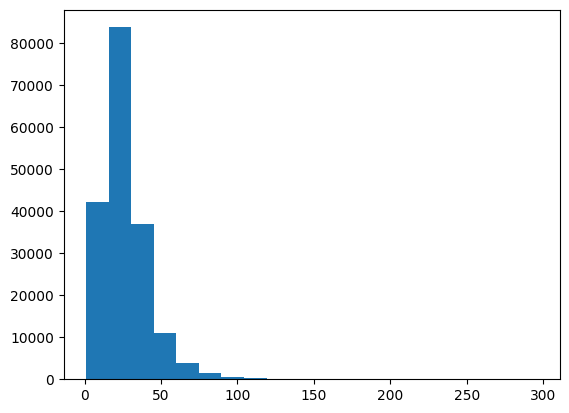

In [ ]:
# What the distributions look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20);

In [ ]:
# How long a sentence length cover 95% of example
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

55

In [ ]:
# Max sequence length in training set
max(sent_lens)

296

## Create Text-vectorizer layer

In [ ]:
# How many words are in training set (20k)
max_tokens=68000 # from paper

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer=TextVectorization(max_tokens=max_tokens, # no of words in vocab
                               output_sequence_length=output_seq_len
                               )

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence=random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\n Length of text:{len(target_sentence.split())}")
print(f"\n Vectorized text:{text_vectorizer([target_sentence])}")

Text:
at high dietary carbohydrate content , the low - compared with high-glycemic index level decreased insulin sensitivity from @ to @ units ( -@ % , p = @ ) ; increased ldl cholesterol from @ to @ mg/dl ( @ % , p. @ ) ; and did not affect levels of hdl cholesterol , triglycerides , or blood pressure .

 Length of text:62

 Vectorized text:[[   15   181   566  2433  1014     2   220    34     7 20504   203   204
    212   277   509    27     6   937    14    96  1360   573    27     6
    772    14     3   112    31   742    93     4  1718   573  1806    16
    107   200     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab=text_vectorizer.get_vocabulary()
print(f"No of words in vocab:{len(rct_20k_text_vocab)}")
print(f"Most comman words in the vocab:{rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab:{rct_20k_text_vocab[-5:]}")

No of words in vocab:64841
Most comman words in the vocab:['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create Custom text embedding

In [ ]:
# Create token embedding
token_embed=layers.Embedding(input_dim=len(rct_20k_text_vocab),
                             output_dim=128,
                             mask_zero=True, #use masking to handle variable sequence lengths (save space)
                             name="token_embedding",
                             )

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
at high dietary carbohydrate content , the low - compared with high-glycemic index level decreased insulin sensitivity from @ to @ units ( -@ % , p = @ ) ; increased ldl cholesterol from @ to @ mg/dl ( @ % , p. @ ) ; and did not affect levels of hdl cholesterol , triglycerides , or blood pressure .

Sentence after vectorization (before embedding):
[[   15   181   566  2433  1014     2   220    34     7 20504   203   204
    212   277   509    27     6   937    14    96  1360   573    27     6
    772    14     3   112    31   742    93     4  1718   573  1806    16
    107   200     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.01448314  0.04093221 -0.01586834 ... -0.00719376 -0.02264
    0.04227474]
  [ 0.03484467 -0.01741383  0.04749036 ... -0.03065575 -0.04524824
    0.03327997]
  [ 0.00290937 -0.04426558  0.00755482 ...  0.00423568 -0.00531106
    0.00537727]
  ..

## Creating dataset (tf.dataAPI)

In [ ]:
# Turning data into Tensorflow Datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_encoded))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_labels_one_hot.shape

(180040, 5)

In [ ]:
# Take tensorslice dataset and turn them into prefetched datasets
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset=valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1 :Conv1D with Embeddings

In [ ]:
num_classes

5

In [ ]:
#Create 1D conv model to process sequences
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs) # vectorize the text inputs
token_embeddings=token_embed(text_vectors) # Create embedding
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x=layers.GlobalAveragePooling1D()(x)# Condense output from conv1d
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_1=tf.keras.Model(inputs,outputs)

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [ ]:
#Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

In [ ]:
# Fit the model
history_model_1=model_1.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=3,
                            validation_data=(valid_dataset),
                            validation_steps=int(0.1*len(valid_dataset))
                            )

Epoch 1/3
562/562 [==============================] - 21s 32ms/step - loss: 0.9287 - accuracy: 0.6321 - val_loss: 0.6916 - val_accuracy: 0.7407
Epoch 2/3
562/562 [==============================] - 5s 10ms/step - loss: 0.6653 - accuracy: 0.7527 - val_loss: 0.6389 - val_accuracy: 0.7683
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6259 - accuracy: 0.7693 - val_loss: 0.6004 - val_accuracy: 0.7859


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6040 - accuracy: 0.7840


[0.6040257811546326, 0.7840262055397034]

In [ ]:
# Make predictions (Model prediction probablities for each class)
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[3.7678164e-01, 2.1089222e-01, 1.1777142e-01, 2.5336534e-01,
        4.1189305e-02],
       [4.7826317e-01, 2.3296781e-01, 1.2339472e-02, 2.7030984e-01,
        6.1196634e-03],
       [1.7541465e-01, 9.5050875e-03, 2.8179677e-03, 8.1220961e-01,
        5.2756204e-05],
       ...,
       [3.2618407e-06, 7.2769471e-04, 7.3745317e-04, 2.1166400e-06,
        9.9852943e-01],
       [6.3088141e-02, 4.5296776e-01, 1.1189638e-01, 7.8282066e-02,
        2.9376563e-01],
       [2.1760866e-01, 5.8139384e-01, 4.4404492e-02, 6.4379461e-02,
        9.2213526e-02]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1_results
model_1_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_1_preds)
model_1_results

{'accuracy': 78.40262147491063,
 'precision': 0.7803319567892704,
 'recall': 0.7840262147491063,
 'f1': 0.7813453909830382}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings

In [ ]:
# Download pretrained TensorFlow hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                      trainable=False,
                                      name="universal_sentence_encoder"
                                      )

In [ ]:
# Testing out pretrained embedding on random sentence
random_train_sentence=random.choice(train_sentences)
print(f"Random sentence :\n {random_train_sentence}")
use_embedded_sentence=tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding:{len(use_embedded_sentence[0])}")

Random sentence :
 results indicated significant between-group differences in measures of problem recognition , desire for help , treatment readiness , and total motivation , with experimental participants having higher treatment motivation means than control participants .
Sentence after embedding
[-0.00236661 -0.07941936  0.02173329 -0.03798876  0.04139939 -0.01974069
 -0.05425744  0.00446068 -0.03794369 -0.01725007 -0.00235911 -0.05723748
  0.05443467 -0.0587239  -0.04702378 -0.01504427 -0.01193289  0.00121875
 -0.01972486 -0.03829763 -0.0059371   0.06648888 -0.04516217 -0.01482225
  0.03895237  0.03897031  0.01160333 -0.00077644 -0.0043052  -0.03298663]

Length of sentence embedding:512


## Model 2 :NLP Feature Extraction model using pretrained Embeddings

In [ ]:
inputs=layers.Input(shape=[],dtype=tf.string)
pretrained_embeddings=tf_hub_embedding_layer(inputs)# tokenize text and create embedding(512 vector)
x=layers.Dense(128,activation="relu")(pretrained_embeddings)
outputs=layers.Dense(num_classes,activation="softmax")(x)#Create the output layer
model_2=tf.keras.Model(inputs,outputs)

In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
history_model_2=model_2.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=3,
                            validation_data=(valid_dataset),
                            validation_steps=int(0.1*len(valid_dataset))
                            )

Epoch 1/3
562/562 [==============================] - 11s 14ms/step - loss: 0.9152 - accuracy: 0.6516 - val_loss: 0.7972 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7686 - accuracy: 0.7013 - val_loss: 0.7531 - val_accuracy: 0.7111
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7509 - accuracy: 0.7120 - val_loss: 0.7369 - val_accuracy: 0.7138


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7401 - accuracy: 0.7149


[0.7400996685028076, 0.7149146199226379]

In [ ]:
model_2_pred_probs=model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[0.42633975, 0.37047952, 0.00198199, 0.19323106, 0.00796773],
       [0.38826618, 0.4751272 , 0.0031697 , 0.13124084, 0.00219599],
       [0.23142238, 0.14383538, 0.01788625, 0.56358784, 0.04326815],
       ...,
       [0.0017441 , 0.00622833, 0.05109289, 0.00096795, 0.93996674],
       [0.00423602, 0.05499024, 0.18479735, 0.00127839, 0.75469804],
       [0.20631725, 0.28425965, 0.45542514, 0.00742724, 0.0465706 ]],
      dtype=float32)

In [ ]:
# Convert pred probs to classes
model_2_preds=tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate model_1_results
model_2_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_2_preds)
model_2_results

{'accuracy': 71.49146034688204,
 'precision': 0.7154465974818351,
 'recall': 0.7149146034688203,
 'f1': 0.7116686092451657}

## Model 3 : Conv1D with character Embedding

### Creating a character-level-tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [ ]:
# Split sequence level data into character-lvl data splits
train_chars=[split_chars(sentence) for sentence in train_sentences]
val_chars=[split_chars(sentence) for sentence in val_sentences]
test_chars=[split_chars(sentence) for sentence in test_sentences]

In [ ]:
# Average character length
char_lens=[len(sentence) for sentence in train_sentences]
mean_char_len=np.mean(char_lens)
mean_char_len

149.3662574983337

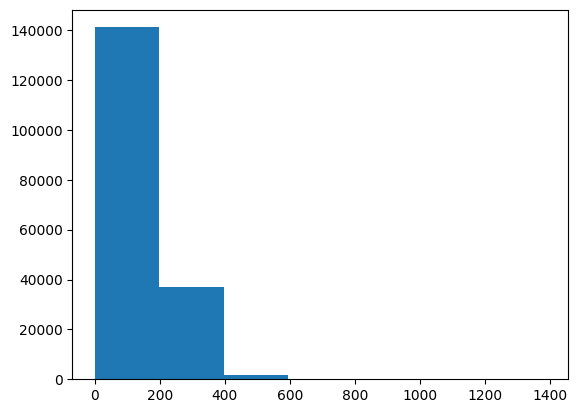

In [ ]:
# Distribution of sequences of character level
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=7);

In [ ]:
# what character length  cover 95% of sequences
output_seq_char_len=int(np.percentile(char_lens,95))
output_seq_char_len

290

In [ ]:
#Get all keyboard characters
import string
alphabet=string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create a character lv token vectorizer instance
NUM_CHAR_TOKENS=len(alphabet)+2 # add 2 for space and <OOV>
char_vectorizer=TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                  output_sequence_length=output_seq_char_len,
                                  name="char_vectorizer"
                                  )

In [ ]:
#Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
#chech chracter vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:

# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   q u a l i t a t i v e   d a t a   i n d i c a t e   t h a t   m u s i c   i m p r o v e s   s y m p t o m   m a n a g e m e n t   ,   e m b o d i e s   h o p e   f o r   s u r v i v a l   ,   a n d   h e l p s   c o n n e c t   t o   a   p r e - i l l n e s s   s e l f   ,   b u t   m a y   a l s o   a c c e s s   m e m o r i e s   o f   l o s s   a n d   t r a u m a   .

Length of chars: 159

Vectorized chars:
[[ 3 13  2 26 16  5 12  4  3  5  3  4 21  2 10  5  3  5  4  6 10  4 11  5
   3  2  3 13  5  3 15 16  9  4 11  4 15 14  8  7 21  2  9  9 19 15 14  3
   7 15 15  5  6  5 18  2 15  2  6  3  2 15 22  7 10  4  2  9 13  7 14  2
  17  7  8  9 16  8 21  4 21  5 12  5  6 10 13  2 12 14  9 11  7  6  6  2
  11  3  3  7  5 14  8  2  4 12 12  6  2  9  9  9  2 12 17 22 16  3 15  5
  19  5 12  9  7  5 11 11  2  9  9 15  2 15  7  8  4  2  9  7 17 12  7  9
   9  5  6 10  3  8  5 16 15  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0

## Creating a character lv embedding

In [ ]:
# Create char embedding layer
char_embed=layers.Embedding(input_dim=len(char_vocab),
                            output_dim=25,#size of char embedding in paper
                            mask_zero=True,
                            name="char_embed"
                            )

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")


Charified text (before vectorization and embedding):
t h e   q u a l i t a t i v e   d a t a   i n d i c a t e   t h a t   m u s i c   i m p r o v e s   s y m p t o m   m a n a g e m e n t   ,   e m b o d i e s   h o p e   f o r   s u r v i v a l   ,   a n d   h e l p s   c o n n e c t   t o   a   p r e - i l l n e s s   s e l f   ,   b u t   m a y   a l s o   a c c e s s   m e m o r i e s   o f   l o s s   a n d   t r a u m a   .

Embedded chars (after vectorization and embedding):
[[[-0.04000754 -0.02666919 -0.04395918 ... -0.0143065   0.04342062
    0.03750134]
  [-0.01346289  0.03781516 -0.04448112 ...  0.03786981 -0.00019203
    0.02778146]
  [-0.0434781  -0.0071123   0.00679346 ...  0.0315076   0.00011523
    0.00216132]
  ...
  [ 0.00576986 -0.04780553 -0.04627433 ...  0.04073304 -0.04395949
   -0.00491538]
  [ 0.00576986 -0.04780553 -0.04627433 ...  0.04073304 -0.04395949
   -0.00491538]
  [ 0.00576986 -0.04780553 -0.04627433 ...  0.04073304 -0.04395949
   -0.00491538]]]

Chara

## Model 3 : Con1D charcater lv embedding

In [ ]:

# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Check the summary of conv1d_char_model
model_3.summary()


Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))


Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2714 - accuracy: 0.4865 - val_loss: 1.0439 - val_accuracy: 0.5824
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0009 - accuracy: 0.6004 - val_loss: 0.9477 - val_accuracy: 0.6280
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9210 - accuracy: 0.6361 - val_loss: 0.8730 - val_accuracy: 0.6646


In [ ]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8830 - accuracy: 0.6590


[0.883049488067627, 0.6589765548706055]

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.20385149, 0.24585673, 0.19616586, 0.23166168, 0.12246424],
       [0.09328658, 0.69851106, 0.01614432, 0.08582906, 0.10622894],
       [0.11473655, 0.14264156, 0.50996214, 0.13900246, 0.09365726],
       ...,
       [0.0113387 , 0.03384797, 0.17146194, 0.01967377, 0.76367766],
       [0.02858542, 0.21869154, 0.20764704, 0.05484561, 0.49023035],
       [0.577394  , 0.22519214, 0.09661588, 0.09372606, 0.00707195]],
      dtype=float32)

In [ ]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 0])>

In [ ]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.89765656030715,
 'precision': 0.6499078045886676,
 'recall': 0.6589765656030716,
 'f1': 0.6494472369234966}

## Model 4 : Combining a pretrained token embedding with character embedding
* Create a token -lv embedding model
* Create a character -lv embedding model
* Combine first two *
* Build a series of output layers on top of 3 similar to figure 1 and section 4.2 of NN for joint sentence classification ``https://arxiv.org/pdf/1612.05251.pdf``

* Construct a model which takes token and character lv sequence as input and produces sequence label probablity as output

In [ ]:
# 1. Setup token inputs/model
token_inputs=layers.Input(shape=[],dtype=tf.string,name="Token input")#shape=[] empty list as Universal sentence encoder expects
token_embedding=tf_hub_embedding_layer(token_inputs)
token_output=layers.Dense(128,activation="relu")(token_embedding)
token_model=tf.keras.Model(token_inputs,token_output)

In [ ]:
#2. Setup char inputs/model
char_inputs=layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vector=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vector)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(char_inputs,char_bi_lstm)


In [ ]:
#3. Concatenate token and character input (hybrid embedding)
token_char_concat=layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                char_model.output])

In [ ]:
#4. Create output layer and adding dropout
combined_dropout=layers.Dropout(0.5) (token_char_concat)
combined_dense=layers.Dense(128,activation="relu")(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes,activation="softmax")(final_dropout)

#5 Contruct model with char and token inputs
model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],
                       outputs=output_layer,
                       name="model_4_token_char_embedding"
                       )

In [ ]:
model_4.summary()

Model: "model_4_token_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Token input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['T

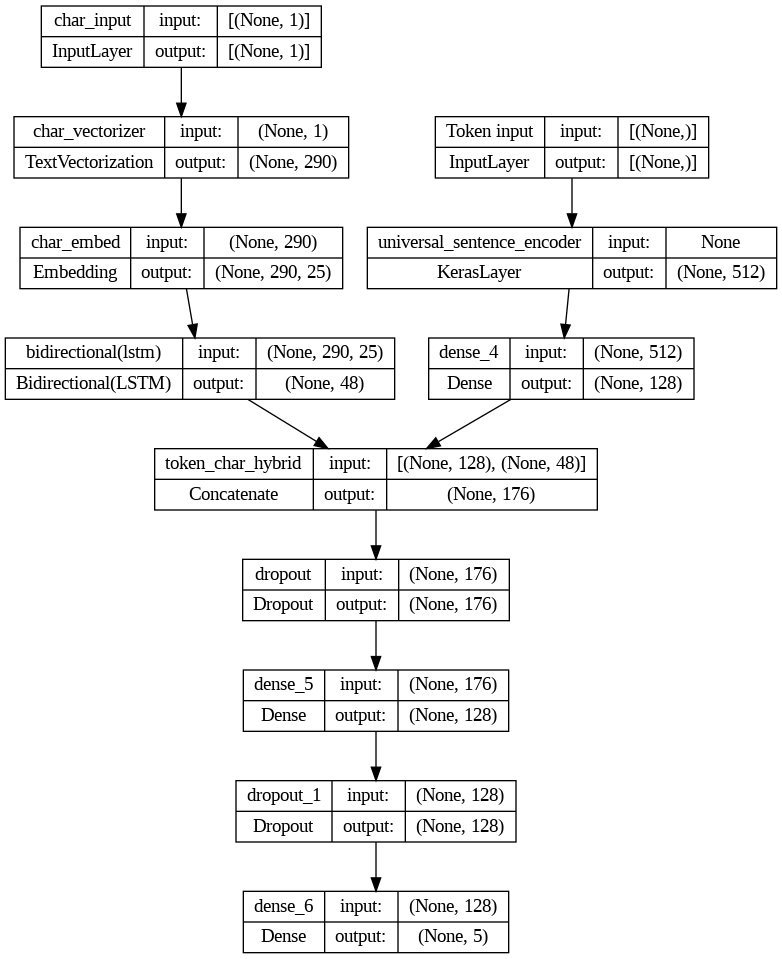

In [ ]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [ ]:
#Compile
model_4.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

## Combining token and character data into tf.data.Dataset


In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Checkout training char and token embedding dataset
train_char_token_dataset,val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting the model

In [ ]:
history_model_4=model_4.fit(train_char_token_dataset,
                            steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                            epochs=3,
                            validation_data=val_char_token_dataset,
                            validation_steps=int(0.1*len(val_char_token_dataset))
                            )

Epoch 1/3
562/562 [==============================] - 58s 72ms/step - loss: 0.9915 - accuracy: 0.6029 - val_loss: 0.7826 - val_accuracy: 0.6971
Epoch 2/3
562/562 [==============================] - 26s 46ms/step - loss: 0.8025 - accuracy: 0.6898 - val_loss: 0.7064 - val_accuracy: 0.7380
Epoch 3/3
562/562 [==============================] - 24s 42ms/step - loss: 0.7736 - accuracy: 0.7074 - val_loss: 0.6859 - val_accuracy: 0.7390


In [ ]:
#Evaluate one the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.6923 - accuracy: 0.7365


[0.6923143863677979, 0.7364954352378845]

In [ ]:

# Make prediction using the token-character model hybrid
model_4_pred_probs=model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 21s 20ms/step


array([[4.25444126e-01, 3.59156460e-01, 4.64515574e-03, 2.05518305e-01,
        5.23593277e-03],
       [3.04032773e-01, 4.65944380e-01, 3.36484914e-03, 2.24461988e-01,
        2.19605467e-03],
       [2.72023827e-01, 1.00837715e-01, 4.31960002e-02, 5.50931811e-01,
        3.30106057e-02],
       ...,
       [8.89205956e-04, 1.08409524e-02, 5.34032397e-02, 3.60399834e-04,
        9.34506178e-01],
       [8.68181791e-03, 5.93413971e-02, 1.89112410e-01, 3.53368931e-03,
        7.39330649e-01],
       [2.55623937e-01, 4.14546669e-01, 2.59817898e-01, 2.11698469e-02,
        4.88416925e-02]], dtype=float32)

In [ ]:
# Format pred probs into pred labels
model_4_preds=tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Get results of token -char hybrid model
model_4_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_4_preds)

In [ ]:
model_4_results

{'accuracy': 73.64954322785648,
 'precision': 0.7383048845428517,
 'recall': 0.7364954322785648,
 'f1': 0.7326705429070148}

## Model 5 :Transfer learning with pretrained token embedding + character embedding + positional embedding

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create Positional Embeddings

In [ ]:
# How many different lines are there
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

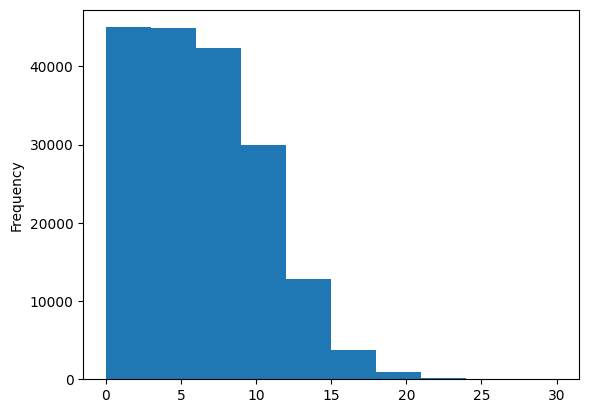

In [ ]:
# Check the distribution of "line number" column
train_df.line_number.plot.hist()

In [ ]:
# Creating one-hot encooded tensor of "line-number" coulumn
train_line_numbers_one_hot=tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df["line_number"].to_numpy(),depth=15)
train_line_numbers_one_hot[:10],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

## One hot total lines


In [ ]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

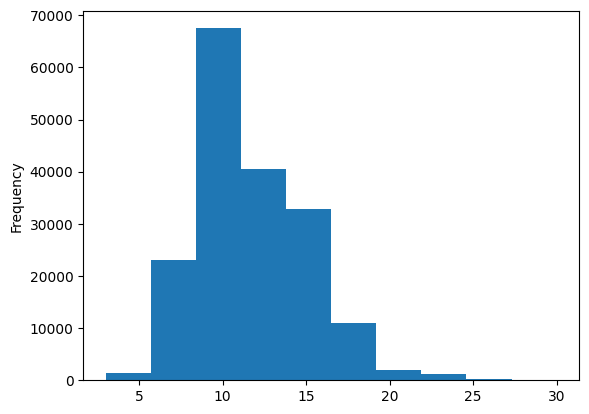

In [ ]:
train_df["total_lines"].plot.hist()

In [ ]:
# Check the coverage of total lines value of 20
np.percentile(train_df.total_lines,98)

20.0

In [ ]:
# Creating one-hot encooded tensor of "total_lines" coulumn
train_total_lines_one_hot=tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot=tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)

## Building a tribid embedding model

In [ ]:
# 1. Token inputs
token_inputs=layers.Input(shape=[],dtype="string",name="token_inputs")
token_embedding=tf_hub_embedding_layer(token_inputs)
token_outputs=layers.Dense(128,activation="relu")(token_embedding)
token_model=tf.keras.Model(inputs=token_inputs,
                           outputs=token_outputs
                           )

#2. Char inputs
char_inputs=layers.Input(shape=(1,),dtype="string",name="char_inputs")
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(inputs=char_inputs,
                          outputs=char_bi_lstm
                          )

In [ ]:
train_line_numbers_one_hot[0].shape

TensorShape([15])

In [ ]:
train_total_lines_one_hot.shape

TensorShape([180040, 20])

In [ ]:
# 3. Line numbers model
line_number_inputs=layers.Input(shape=(15,),dtype=tf.float32,name="line_number_input")
x=layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model=tf.keras.Model(inputs=line_number_inputs,outputs=x)

#4. Total line model
total_line_inputs=layers.Input(shape=(20,),dtype=tf.float32,name="total_lines_input")
y=layers.Dense(32,activation="relu")(total_line_inputs)
total_line_model=tf.keras.Model(inputs=total_line_inputs,
                                outputs=y
                                )

In [ ]:
# 5. Combine token and char embedding ino hybrid embeddig
combined_embeddings=layers.Concatenate(name="char_token_embedding")([token_model.output,char_model.output])

z=layers.Dense(256,activation="relu")(combined_embeddings)
z=layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embedding
tribid_embeddings=layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                              total_line_model.output,
                                                                              z
                                                                              ])
#7. create output layer
output_layer=layers.Dense(5,activation="softmax",name="output_layer")(tribid_embeddings)

#8 Model
model_5=tf.keras.Model(inputs=[line_number_model.input,
                               total_line_model.input,
                               token_model.input,
                               char_model.input
                               ],
                       outputs=output_layer,
                       name="Tribid_embedding_model"
                       )

In [ ]:
model_5.summary()

Model: "Tribid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_i

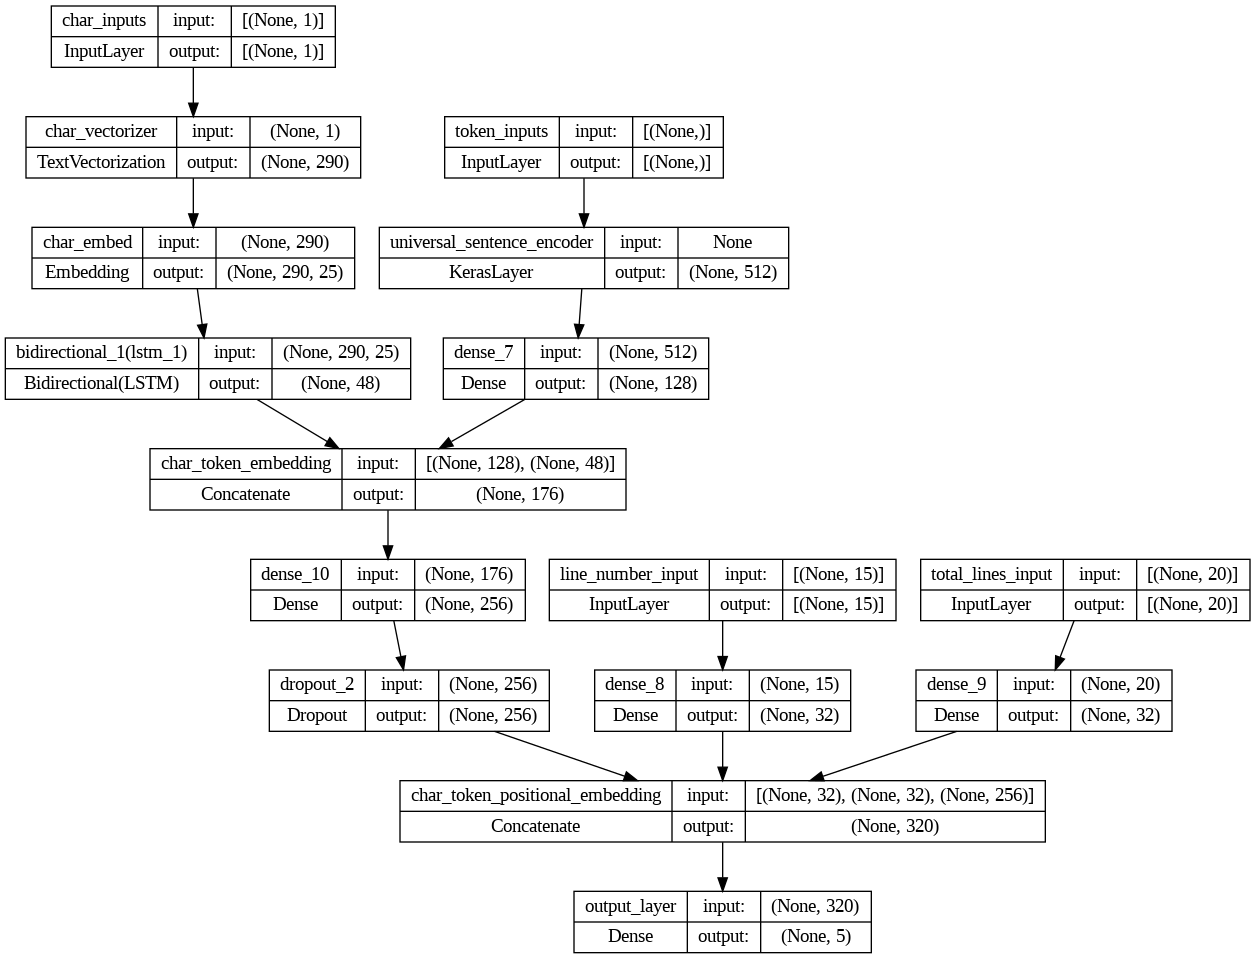

In [ ]:
# Plot hybrid token ,linear model and character model
from keras.utils import plot_model
plot_model(model_5,show_shapes=True)

In [ ]:
#Compile token,char and positional model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),# Helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=10,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset))
                              )

Epoch 1/10
562/562 [==============================] - 45s 79ms/step - loss: 0.9405 - accuracy: 0.8332 - val_loss: 0.9285 - val_accuracy: 0.8428
Epoch 2/10
562/562 [==============================] - 26s 46ms/step - loss: 0.9228 - accuracy: 0.8468 - val_loss: 0.9206 - val_accuracy: 0.8444
Epoch 3/10
562/562 [==============================] - 24s 43ms/step - loss: 0.9176 - accuracy: 0.8481 - val_loss: 0.9241 - val_accuracy: 0.8394
Epoch 4/10
562/562 [==============================] - 27s 48ms/step - loss: 0.9247 - accuracy: 0.8449 - val_loss: 0.9160 - val_accuracy: 0.8434
Epoch 5/10
562/562 [==============================] - 26s 47ms/step - loss: 0.9250 - accuracy: 0.8437 - val_loss: 0.9122 - val_accuracy: 0.8504
Epoch 6/10
562/562 [==============================] - 26s 46ms/step - loss: 0.9308 - accuracy: 0.8365 - val_loss: 0.9117 - val_accuracy: 0.8511
Epoch 7/10
562/562 [==============================] - 31s 56ms/step - loss: 0.9198 - accuracy: 0.8460 - val_loss: 0.9120 - val_accuracy:

In [ ]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 20s 21ms/step


array([[0.54772496, 0.0976569 , 0.01646896, 0.3124176 , 0.02573163],
       [0.55068105, 0.10405486, 0.08430001, 0.23948067, 0.02148343],
       [0.38409787, 0.09434786, 0.07029331, 0.40369767, 0.04756337],
       ...,
       [0.01916429, 0.05608298, 0.01886727, 0.02614143, 0.879744  ],
       [0.01977413, 0.29167378, 0.07749063, 0.02454985, 0.5865116 ],
       [0.07173106, 0.8242807 , 0.04933732, 0.02583151, 0.02881934]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results


{'accuracy': 85.56864821925063,
 'precision': 0.8570545369078826,
 'recall': 0.8556864821925063,
 'f1': 0.8527442545245283}

## Model 6: Using Transformers (BERT)

In [ ]:
!pip install tensorflow-hub
!pip install tensorflow-text
import tensorflow as tf
import tensorflow_hub as hub
!pip install sentencepiece

In [ ]:
import tensorflow_text as text

In [ ]:
preprocessor = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")

In [ ]:
bert_preprocess = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
#1. Bert layers
text_input=tf.keras.layers.Input(shape=[],dtype=tf.string,name="token_inputs")
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)
#Neural Networks
dropout=tf.keras.layers.Dropout(0.2,name="dropout")(outputs['pooled_output'])
output_1=tf.keras.layers.Dense(128,activation="relu")(dropout)
token_model=tf.keras.Model(inputs=text_input,
                           outputs=output_1
                           )

#2. Char inputs
char_inputs=layers.Input(shape=(1,),dtype="string",name="char_inputs")
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(inputs=char_inputs,
                          outputs=char_bi_lstm
                          )


In [ ]:
# 3. Line numbers model
line_number_inputs=layers.Input(shape=(15,),dtype=tf.float32,name="line_number_input")
x=layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model=tf.keras.Model(inputs=line_number_inputs,outputs=x)

#4. Total line model
total_line_inputs=layers.Input(shape=(20,),dtype=tf.float32,name="total_lines_input")
y=layers.Dense(32,activation="relu")(total_line_inputs)
total_line_model=tf.keras.Model(inputs=total_line_inputs,
                                outputs=y
                                )

In [ ]:
# 5. Combine token and char embedding ino hybrid embeddig
combined_embeddings=layers.Concatenate(name="char_token_embedding")([token_model.output,char_model.output])

z=layers.Dense(256,activation="relu")(combined_embeddings)
z=layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embedding
tribid_embeddings=layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                              total_line_model.output,
                                                                              z
                                                                              ])
#7. create output layer
output_layer=layers.Dense(5,activation="softmax",name="output_layer")(tribid_embeddings)

#8 Model
model_6=tf.keras.Model(inputs=[line_number_model.input,
                               total_line_model.input,
                               token_model.input,
                               char_model.input
                               ],
                       outputs=output_layer,
                       name="Tribid_embedding_model"
                       )

In [ ]:
model_6.summary()


Model: "Tribid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 keras_layer_4 (KerasLayer)  {'input_word_ids': (None,    0         ['token_inputs[0][0]']        
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                             

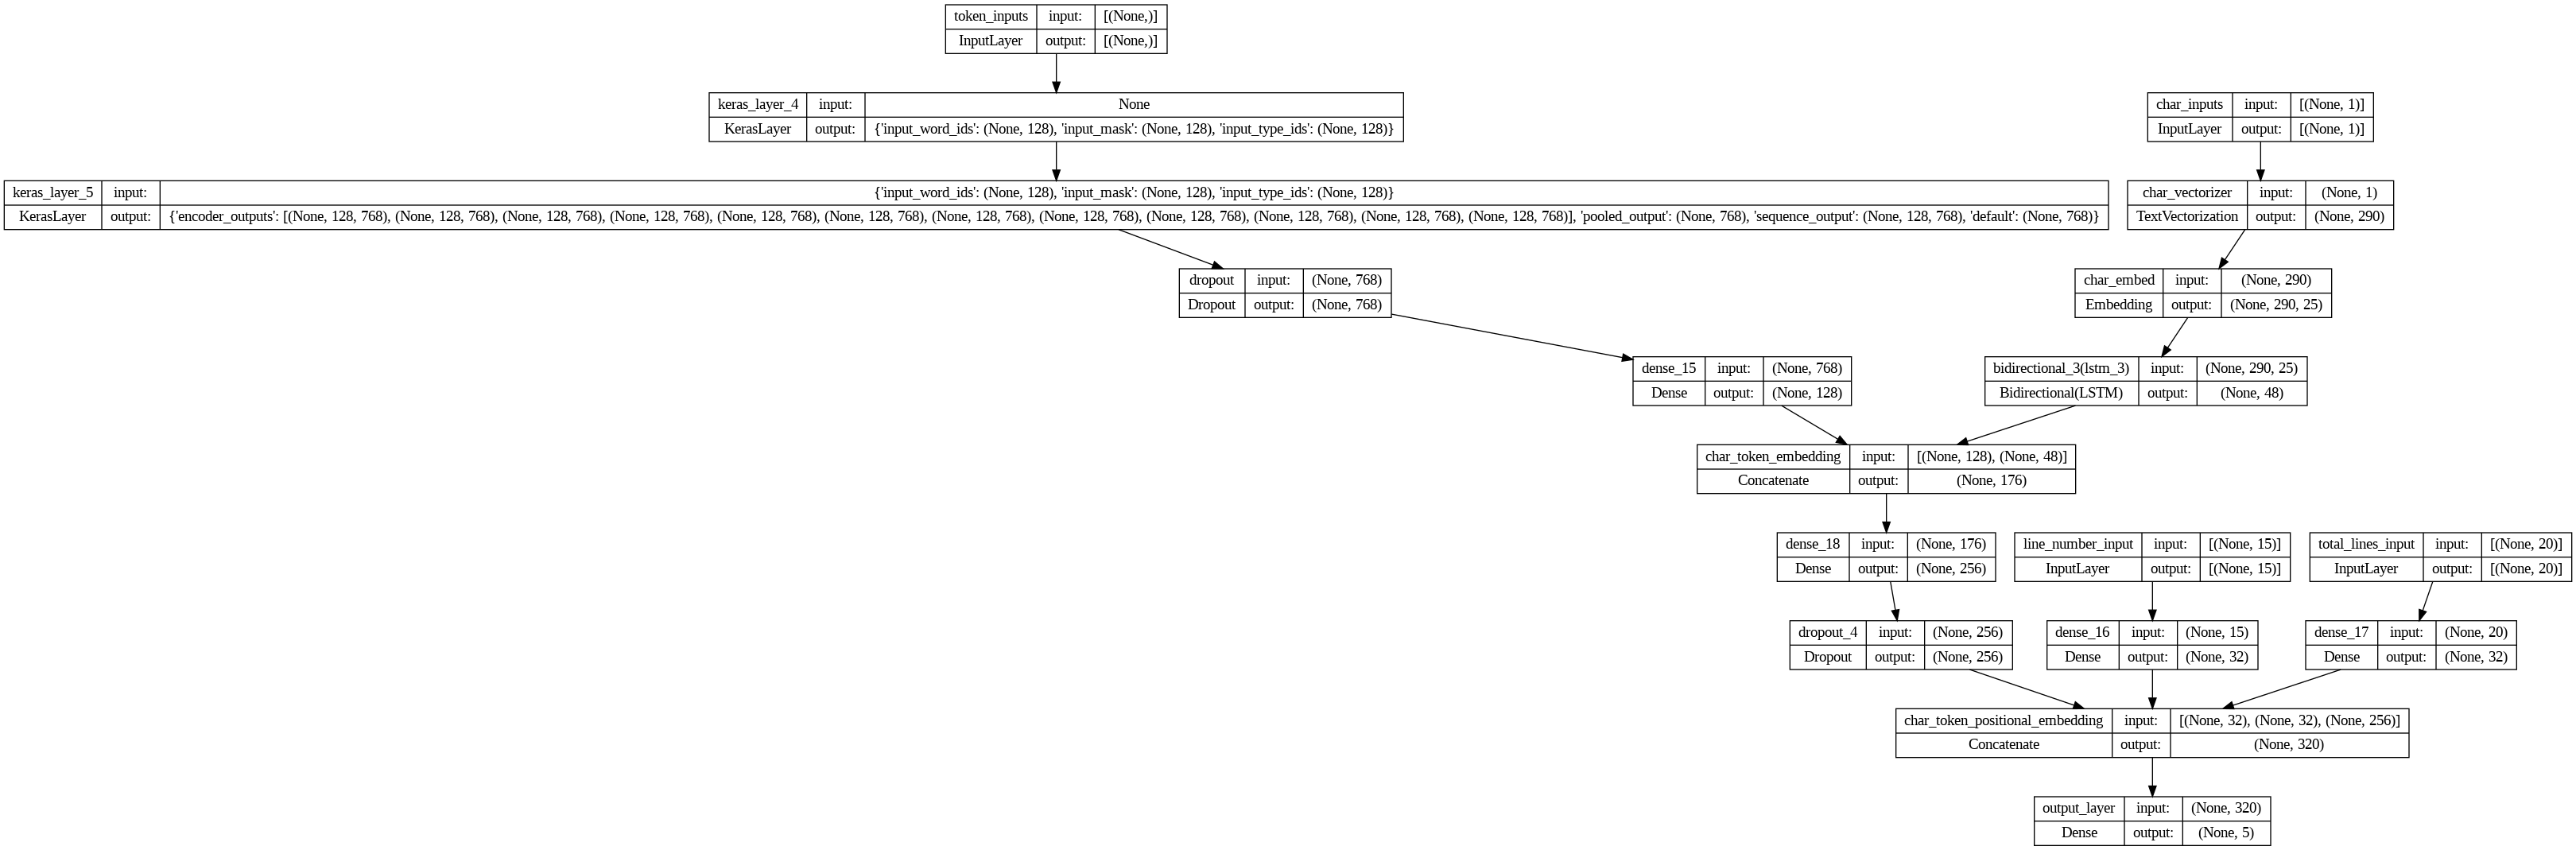

In [ ]:
# Plot hybrid token ,linear model and character model
from keras.utils import plot_model
plot_model(model_6,show_shapes=True)

In [ ]:
#Compile token,char and positional model
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),# Helps to prevent overfitting
                optimizer=tf.keras.optimizers.AdamW(),
                metrics=["accuracy"]
                )

In [ ]:

# Fit the token, char and positional embedding model
history_model_6 = model_6.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=5,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset))
                              )

Epoch 1/5
562/562 [==============================] - 243s 432ms/step - loss: 1.0066 - accuracy: 0.7842 - val_loss: 0.9745 - val_accuracy: 0.8065
Epoch 2/5
562/562 [==============================] - 235s 419ms/step - loss: 0.9827 - accuracy: 0.8067 - val_loss: 0.9467 - val_accuracy: 0.8381
Epoch 3/5
562/562 [==============================] - 243s 432ms/step - loss: 0.9769 - accuracy: 0.8052 - val_loss: 0.9480 - val_accuracy: 0.8275
Epoch 4/5
562/562 [==============================] - 246s 438ms/step - loss: 0.9657 - accuracy: 0.8181 - val_loss: 0.9514 - val_accuracy: 0.8251
Epoch 5/5
562/562 [==============================] - 234s 416ms/step - loss: 0.9615 - accuracy: 0.8179 - val_loss: 0.9478 - val_accuracy: 0.8285


# Model 7: SelfAttention

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [ ]:
train_sentences_count = len(train_sentences)
val_sentences_count = len(val_sentences)
test_sentences_count = len(test_sentences)
total_sentences_count = train_sentences_count + val_sentences_count + test_sentences_count

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [ ]:
# Get class names and number of classes from label_encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

In [ ]:
line_one_hot_encoder = OneHotEncoder(sparse=False)
train_lines_encoded = line_one_hot_encoder.fit_transform(train_df["line_number"].to_numpy().reshape(-1, 1)).astype(np.float32)
val_lines_encoded = line_one_hot_encoder.transform(val_df["line_number"].to_numpy().reshape(-1, 1)).astype(np.float32)
test_lines_encoded = line_one_hot_encoder.transform(test_df["line_number"].to_numpy().reshape(-1, 1)).astype(np.float32)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
test_lines_encoded.shape

(30135, 31)

In [ ]:
def apply_smoothing(line_one_hot, esp=0.01):
    return np.abs(line_one_hot - esp)

def revert_smoothing(line_one_hot_smooth, esp=0.01):
    unsmooth = line_one_hot_smooth

    unsmooth[unsmooth>esp] = 1.0
    unsmooth[unsmooth<=esp] = 0.0

    return unsmooth

In [ ]:
# Only apply smoothing to train lines feature
train_lines_encoded = apply_smoothing(train_lines_encoded)

In [ ]:
def create_pipeline(features, labels, batch_size=32, shuffle=False, cache=False, prefetch=False) -> tf.data.Dataset:
    '''
    Generates an input pipeline using the tf.data API for training and inference.

    @params
        - features: (tuple) -> tuple containing the feature data
        - labels: (tf.Tensor | np.ndarray, default=None) -> target data related to the feature data
        - batch_size: (int) -> size for batched (default=32)
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (bool) -> condition for caching data, data is cached in memory when True (default=False)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)

    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''

    AUTOTUNE = tf.data.AUTOTUNE

    # Create dataset with features and labels
    ds = tf.data.Dataset.from_tensor_slices((features, labels))

    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    # Apply batching
    ds = ds.batch(batch_size)

    # Apply caching based on condition
    # Note: Do this if the data is small enough to fit in memory!!!
    if cache:
        ds = ds.cache(buffer_size=AUTOTUNE)

    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)

    # Return the dataset
    return ds

In [ ]:
BATCH_SIZE = 32

# Create preprocessed training dataset
train_features = (train_sentences, train_lines_encoded.astype(np.float32))
train_labels = train_labels_one_hot.astype(np.float32)

# Create preprocessed train input data pipeline
train_ds = create_pipeline(
    train_features, train_labels,
    batch_size=BATCH_SIZE, shuffle=True,
    cache=False, prefetch=True)

In [ ]:
# Create preprocessed validation dataset
val_features = (val_sentences, val_lines_encoded.astype(np.float32))
val_labels = val_labels_one_hot.astype(np.float32)

# Create preprocessed validation input data pipeline
val_ds = create_pipeline(val_features, val_labels,
                         batch_size=BATCH_SIZE, shuffle=False,
                         cache=False, prefetch=True)

In [ ]:
# Create preprocessed test dataset
test_features = (test_sentences, test_lines_encoded.astype(np.float32))
test_labels = test_labels_one_hot.astype(np.float32)

# Create preprocessed test input data pipeline
test_ds = create_pipeline(test_features, test_labels,
                          batch_size=BATCH_SIZE, shuffle=False,
                          cache=False, prefetch=True)

In [ ]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 31), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 31), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Test Input Data Pipeline:

 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 31), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


In [ ]:
# When using tensorflow_text, uncomment the line below to import the module
# import tensorflow_text as text

# Here's a function to get any model/preprocessor from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [ ]:
# get Universal Sentence Encoder here
encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'
encoder_trainable=False # set trainable to False for inference-only

encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

In [ ]:
class SelfAttentionBlock(layers.Layer):

    def __init__(self, units: int, activation='gelu', kernel_initializer='GlorotNormal', **kwargs):
        super(SelfAttentionBlock, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.kernel_initializer = tf.keras.initializers.deserialize(kernel_initializer)

        self.query = layers.LSTM(self.units, activation=self.activation,
                                 kernel_initializer=self.kernel_initializer,
                                 return_sequences=True, name=f'block_query_lstm')

        self.value = layers.LSTM(self.units, activation=self.activation,
                                 kernel_initializer=self.kernel_initializer, go_backwards=True,
                                 return_sequences=True, name=f'block_value_lstm')

        self.attention = layers.AdditiveAttention(name='block_attention')
        self.average_pooler = layers.GlobalAveragePooling1D(name='block_average_pooler')
        self.query_batch_norm = layers.BatchNormalization(name='block_query_batch_norm')
        self.attention_batch_norm = layers.BatchNormalization(name='block_attention_batch_norm')
        self.residual = layers.Add(name='block_residual')


    def __call__(self, x):
        # Expand dimensions for LSTMs
        dim_expand_layer = layers.Lambda(lambda embedding: tf.expand_dims(embedding, axis=1), name='block_dim_expand')
        x_expanded = dim_expand_layer(x)

        # Generate LSTM sequences
        block_query = self.query(x_expanded)
        block_value = self.value(x_expanded)

        # Apply self-attention to LSTM
        block_attention = self.attention([block_query, block_value])

        # Apply GlobalAvgPooling and BatchNorm to ensure output shape is 1D
        block_query_pooling = self.average_pooler(block_query)
        block_query_batch_norm = self.query_batch_norm(block_query_pooling)

        block_attention_pooling = self.average_pooler(block_attention)
        block_attention_batch_norm = self.attention_batch_norm(block_attention_pooling)

        # Generate addition residual with processed query and attention
        block_residual = self.residual([block_query_batch_norm, block_attention_batch_norm])

        return block_residual

In [ ]:
def build_model():
    # Model Inputs
    #------------
    abstract_input = layers.Input(shape=[], dtype=tf.string, name='abstract_text_input')
    abstract_current_line = layers.Input(shape=(31), dtype=tf.float32, name='abstract_current_line')

    # Define Layer Initializer
    #------------
    initializer = tf.keras.initializers.GlorotNormal()

    # Text Embedding
    #------------
    abstract_embedding = encoder(abstract_input)

    # Self Attention Block Stream
    #------------
    add_attention_block = SelfAttentionBlock(64)(abstract_embedding)
    abstract_dense = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(abstract_embedding)
    attention_residual = layers.Multiply(name='mul_residual')([add_attention_block, abstract_dense])

    # Current Line Stream
    #------------
    current_line_dense = layers.Dense(32, activation='gelu', kernel_initializer=initializer)(abstract_current_line)
    current_line_dense = layers.Dropout(0.2)(current_line_dense)

    # Concat Streams
    #------------
    streams_concat = layers.Concatenate()([
        attention_residual,
        current_line_dense
    ])

    # Output Layer
    #------------
    output_layer = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(streams_concat)
    output_layer = layers.Dense(5, activation='softmax', kernel_initializer=initializer)(output_layer)

    return tf.keras.Model(inputs=[abstract_input,
                                  abstract_current_line],
                          outputs=[output_layer], name="use_attention_model")

In [ ]:
# Build model
model_7 = build_model()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
# View summary of model
model_7.summary()

Model: "use_attention_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 abstract_text_input (Input  [(None,)]                    0         []                            
 Layer)                                                                                           
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['abstract_text_input[0][0]'] 
  (KerasLayer)                                            24                                      
                                                                                                  
 block_dim_expand (Lambda)   (None, 1, 512)               0         ['universal_sentence_encoder[0
                                                                    ][0]']      

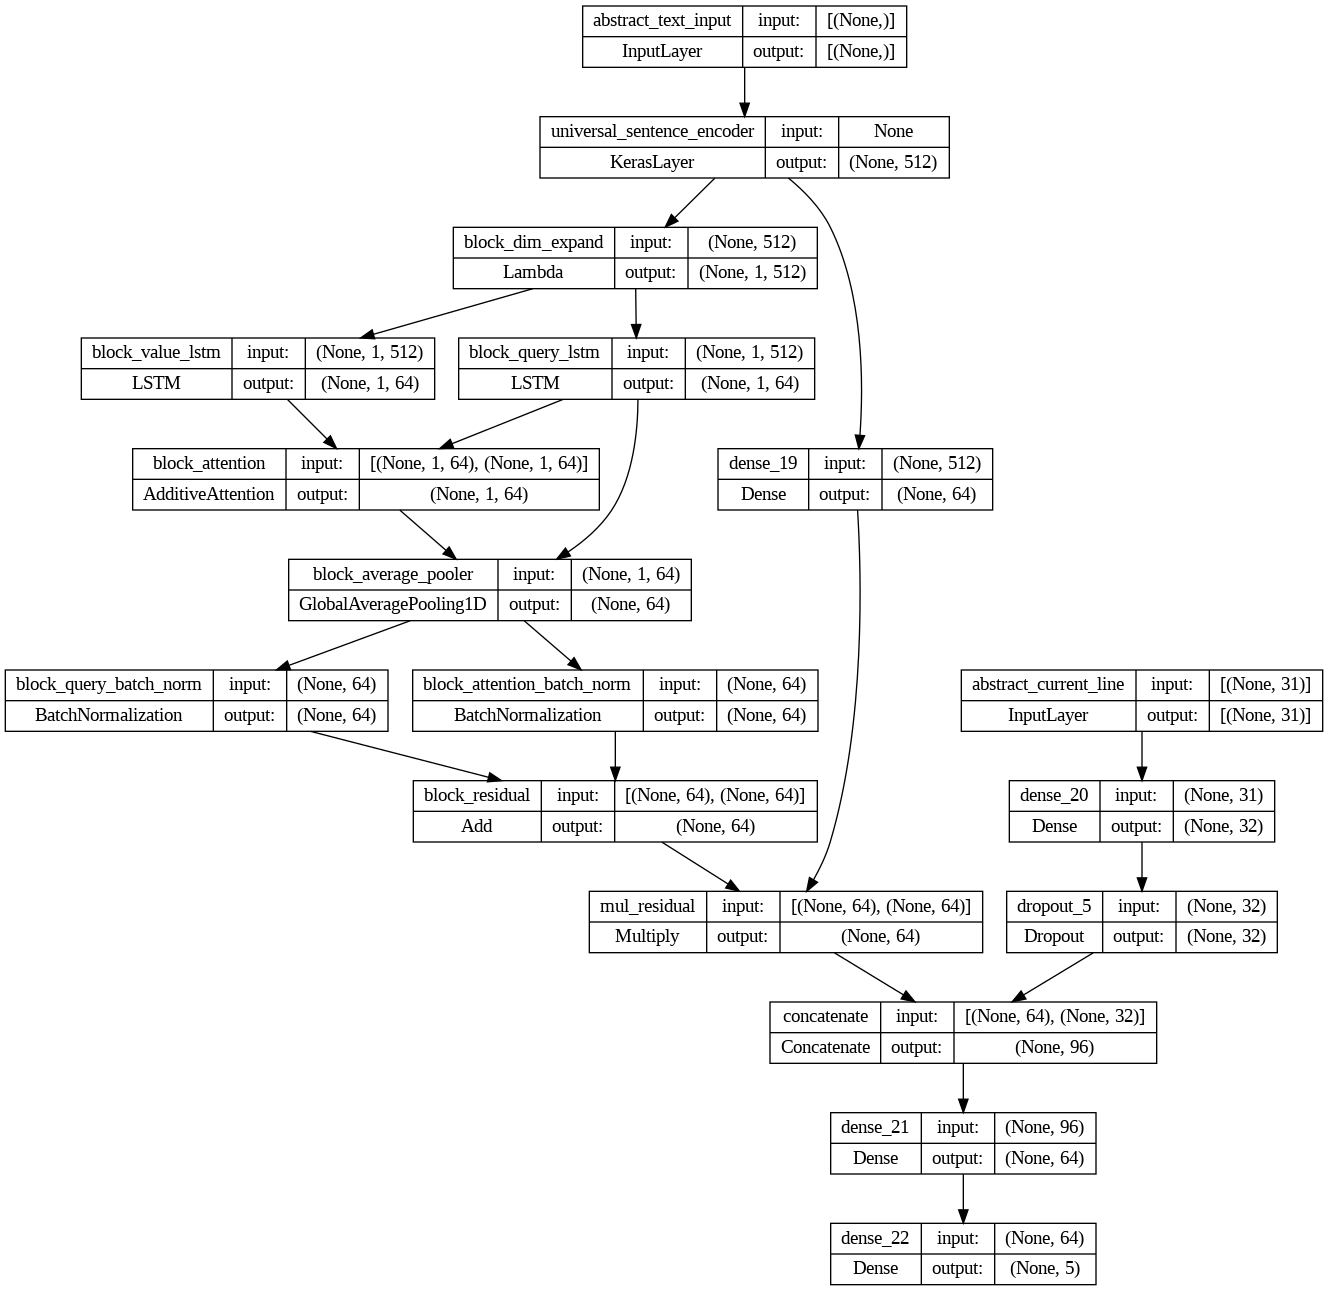

In [ ]:
# Explore model visually
plot_model(
    model_7,
    show_shapes=True,
    expand_nested=True
)

In [ ]:
def train_model(model, num_epochs, callbacks_list, tf_train_data,
                tf_valid_data=None, shuffling=False):
    '''
        Trains a TensorFlow model and returns a dict object containing the model metrics history data.

        @params
        - model: (tf.keras.model) -> model to be trained
        - num_epochs: (int) -> number of epochs to train the model
        - callbacks_list: (list) -> list containing callback fuctions for model
        - tf_train_data: (tf.data.Dataset) -> dataset for model to be train on
        - tf_valid_data: (tf.data.Dataset) -> dataset for model to be validated on (default=None)
        - shuffling: (bool) -> condition for data shuffling, data is shuffled when True (default=False)

        @returns
        - model_history: (dict) -> dictionary containing loss and metrics values tracked during training
    '''

    model_history = {}

    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)

    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

EPOCHS = 5
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

In [ ]:
tf.random.set_seed(42)

model_7.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

print(f'Training {model_7.name}.')
print(f'Train on {train_sentences_count} samples, validate on {val_sentences_count} samples.')
print('----------------------------------')

model_history = train_model(
    model_7, EPOCHS, CALLBACKS,
    train_ds, val_ds,
    shuffling=False
)

Training use_attention_model.
Train on 180040 samples, validate on 30212 samples.
----------------------------------
Epoch 1/5
5627/5627 [==============================] - 148s 25ms/step - loss: 0.7424 - accuracy: 0.8212 - val_loss: 0.6951 - val_accuracy: 0.8422 - lr: 0.0010
Epoch 2/5
5627/5627 [==============================] - 138s 25ms/step - loss: 0.6838 - accuracy: 0.8487 - val_loss: 0.6881 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 3/5
5627/5627 [==============================] - 134s 24ms/step - loss: 0.6647 - accuracy: 0.8589 - val_loss: 0.6840 - val_accuracy: 0.8487 - lr: 0.0010
Epoch 4/5
5627/5627 [==============================] - 131s 23ms/step - loss: 0.6513 - accuracy: 0.8662 - val_loss: 0.6907 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 5/5
5626/5627 [============================>.] - ETA: 0s - loss: 0.6402 - accuracy: 0.8729
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5627/5627 [==============================] - 128s 23ms/step - loss: 0.640

In [ ]:
# evaluate the model on the test data to see how it performs
model_7.evaluate(test_ds)

942/942 [==============================] - 11s 12ms/step - loss: 0.7064 - accuracy: 0.8390


[0.706415057182312, 0.8389912247657776]

In [ ]:
# generate validation probabilities
val_probabilities = model_7.predict(val_ds, verbose=1)

945/945 [==============================] - 11s 11ms/step


In [ ]:
# generate validation predictions with argmax
val_predictions = tf.argmax(val_probabilities, axis=1)

In [ ]:
# generate test probabilities
test_probabilities = model_7.predict(test_ds, verbose=1)

942/942 [==============================] - 10s 11ms/step


In [ ]:
# generate test predictions with argmax
test_predictions = tf.argmax(test_probabilities, axis=1)

In [ ]:
from sklearn.metrics import (
    accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef,
    classification_report, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay
)

In [ ]:
# Generate validation classification report
print(classification_report(val_labels_encoded, val_predictions, target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND       0.70      0.85      0.77      3449
 CONCLUSIONS       0.87      0.82      0.85      4582
     METHODS       0.89      0.90      0.89      9964
   OBJECTIVE       0.81      0.48      0.60      2376
     RESULTS       0.86      0.89      0.87      9841

    accuracy                           0.84     30212
   macro avg       0.82      0.79      0.80     30212
weighted avg       0.85      0.84      0.84     30212



In [ ]:
# Generate test classification report
print(classification_report(test_labels_encoded, test_predictions, target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND       0.70      0.85      0.77      3621
 CONCLUSIONS       0.87      0.82      0.84      4571
     METHODS       0.88      0.90      0.89      9897
   OBJECTIVE       0.80      0.47      0.59      2333
     RESULTS       0.85      0.87      0.86      9713

    accuracy                           0.84     30135
   macro avg       0.82      0.78      0.79     30135
weighted avg       0.84      0.84      0.84     30135



## Compare model results

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.402621,0.780332,0.784026,0.781345
pretrained_token_embed,71.491460,0.715447,0.714915,0.711669
custom_char_embed_conv1d,65.897657,0.649908,0.658977,0.649447
hybrid_char_token_embed,73.649543,0.738305,0.736495,0.732671
tribrid_pos_char_token_embed,85.568648,0.857055,0.855686,0.852744


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

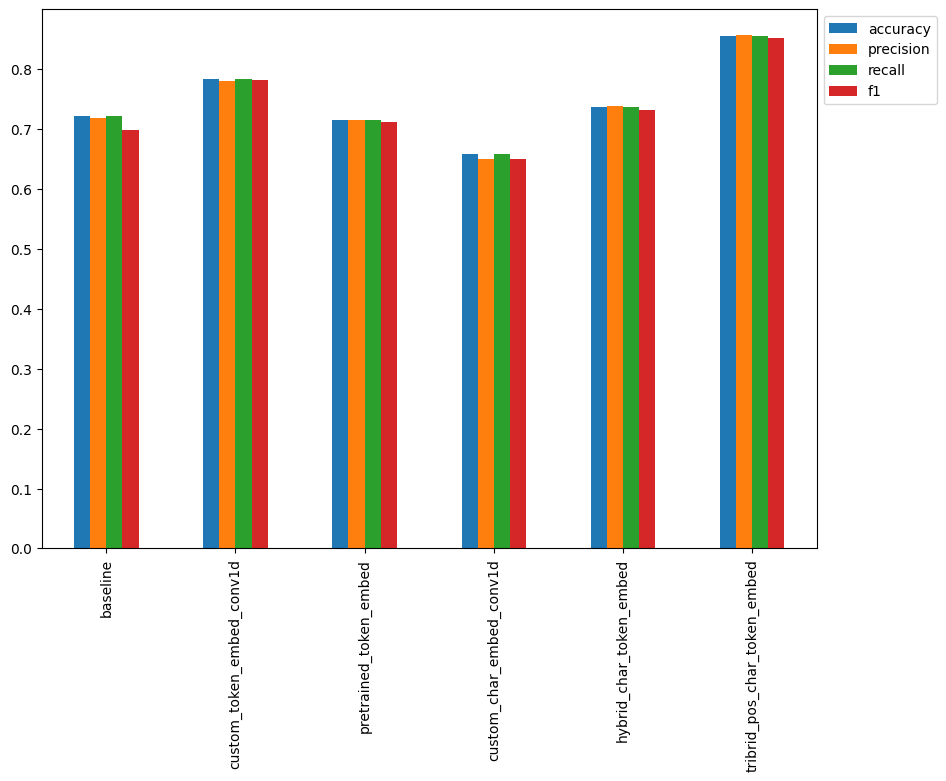

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

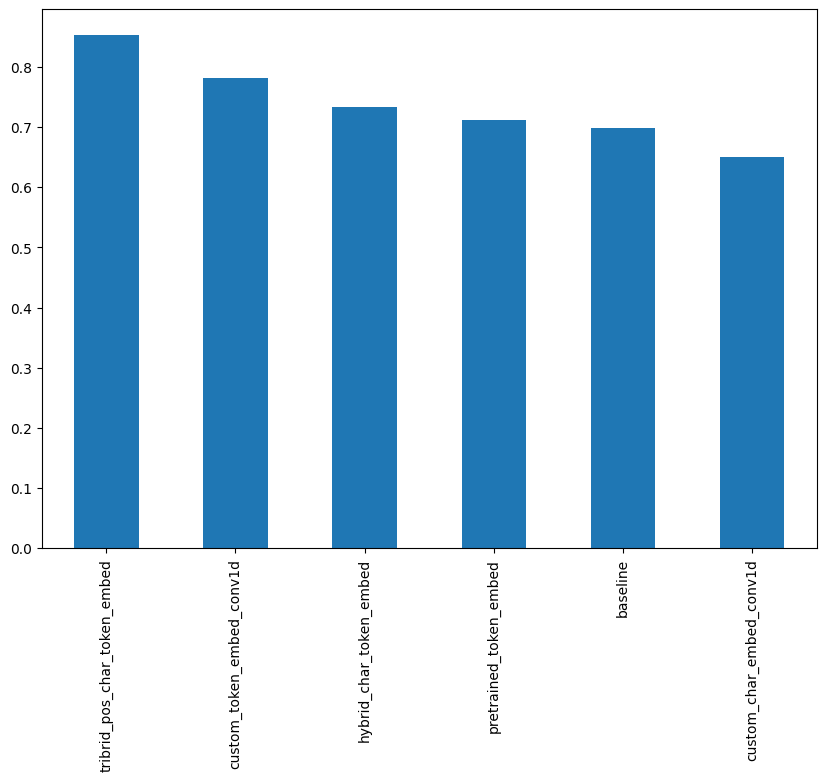

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Working of Model on sample extract

In [ ]:
# Extract labels and encoder them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
# Extract labels and encoder them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
!wget https://raw.githubusercontent.com/Muditkumar123/Deep_learning_Projects-/main/Medi_parse_example_abstracts.json

--2024-03-11 06:19:13--  https://raw.githubusercontent.com/Muditkumar123/Deep_learning_Projects-/main/Medi_parse_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘Medi_parse_example_abstracts.json’

Medi_parse_example_ 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-03-11 06:19:14 (44.8 MB/s) - ‘Medi_parse_example_abstracts.json’ saved [6737/6737]



In [ ]:
# Using json to load in our abstract sample
import json
with open('/content/Medi_parse_example_abstracts.json' , 'r') as f:
  example_abstracts = json.load(f)

example_abstracts

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
pd.DataFrame(example_abstracts)

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
from spacy.lang.en import English

In [ ]:
def visualize_pred_sequence_labels(abstract_dict , model , label_encoder):

  '''

    Takes in a list of dictionaries of abstracts,

    [{'abstract': 'This RCT examined .......' ,
      'details': 'RCT of a manuali......',
      'source': 'https://pubmed.ncbi.nlm........./'},..........]

    Arguments:
    ----------
      - abstract_dict : Abstract dictionary of the above format
      - model : the trained model on the same data format (line_numbers,  total_lines , sentences , characters)
      - label_encoder : the label encoder used to encode the classes

    Returns:
    --------
      Prints out the predicted label and the corresponding sequence/ text
  '''

  # Setup english sentence parser
  nlp = English()

  # Create sentence splitting pipeline object
  nlp.add_pipe('sentencizer')

  # Create doc of parsed sequences
  doc = nlp(abstract_dict[0]['abstract'])

  # Return detected sentences from doc in string typpe
  abstract_lines = [str(sent) for sent in list(doc.sents)]

  # Get total number of lines
  total_lines_in_sample = len(abstract_lines)

  # Loop through each line in the abstract and create a list of dictionaries containing features
  sample_lines = []
  for i , line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict['text'] = str(line)
    sample_dict['line_number'] = i
    sample_dict['total_lines'] = total_lines_in_sample - 1
    sample_lines.append(sample_dict)


  # Get all line number and total lines numbers then one hot encode them
  abstract_line_numbers = [line['line_number'] for line in sample_lines]
  abstract_total_lines = [line['total_lines'] for line in sample_lines]

  abstract_line_numbers_one_hot = tf.one_hot(abstract_line_numbers , depth = 15)
  abstract_total_lines_one_hot = tf.one_hot(abstract_total_lines , depth = 20)


  # Split the lines into characters
  abstract_chars = [split_chars(sentence) for sentence in abstract_lines]

  # Making prediction on sample features
  abstract_pred_probs = model.predict(x = (abstract_line_numbers_one_hot,
                                           abstract_total_lines_one_hot ,
                                           tf.constant(abstract_lines) ,
                                           tf.constant(abstract_chars)))

  # Turn prediction probs to pred class
  abstract_preds = tf.argmax(abstract_pred_probs , axis = 1)

  # Prediction class integers into string class name
  abstract_pred_classes = [label_encoder.classes_[i] for i in abstract_preds]

  # Prints out the abstract lines and the predicted sequence labels
  for i , line in enumerate(abstract_lines):
    print(f'{abstract_pred_classes[i]}:  {line}\n')

In [ ]:
visualize_pred_sequence_labels(example_abstracts , model_5 , label_encoder)

1/1 [==============================] - 2s 2s/step
OBJECTIVE:  This RCT examined the efficacy of a manualized social intervention for children with HFASDs.

METHODS:  Participants were randomly assigned to treatment or wait-list conditions.

METHODS:  Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.

METHODS:  A response-cost program was applied to reduce problem behaviors and foster skills acquisition.

RESULTS:  Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).

METHODS:  Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.

RESULTS:  High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.

RESULTS:  Standardized effect size estimates were primarily in the medium and large ranges